# seq2seq (Sequence-to-sequence)

In [2]:
# 모델 시각화 패키지 install
!pip install pydot pydotplus graphviz

### Embedding Vector 준비

1. 영어 glove 임베딩(사전 학습) 사용 / 6B tokens, 400K vocab, uncased, 100d
2. 한국어 임베딩 (초기 훈련)

In [3]:
# !gdown 1UK61mxiWzP1XPvJ53KXa7L7-ETbDYKgc

### 학습 데이터 준비

http://www.manythings.org/anki/

eng-kor 짝으로 이루어진 학습 데이터

1. Encoder 입력 데이터 eng
    - encoder_input_eng 준비 `I love you`
2. Decoder 출력 데이터 kor
    - 학습용 teacher-forcing 모델
        - decoder_input_kor `<sos> 난 널 사랑해`
        - decoder_output_kor `난 널 사랑해 <eos>`
    - 추론용 모델

In [4]:
# !gdown 1sfIbATWOTpYiJZbl9NClZ9ZhbSvdR1Wz -O eng_kor.txt

In [5]:
eng_inputs = [] #인코더 입력
kor_inputs = [] #디코더 입력
kor_targets = [] #디코더 출력

with open('eng_kor.txt', 'r', encoding='utf-8') as f:
    for line in f:
        eng, kor, _ = line.split('\t')

        kor_input = '<sos> ' + kor
        kor_target = kor + ' <eos>'

        eng_inputs.append(eng)
        kor_inputs.append(kor_input)
        kor_targets.append(kor_target)

len(eng_inputs), len(kor_inputs), len(kor_targets)

(5890, 5890, 5890)

In [6]:
print(eng_inputs[1000:1005])
print(kor_inputs[1000:1005])
print(kor_targets[1000:1005])

["I'm just sleepy.", "I'm not sulking.", "I'm on the list.", 'Is Tom with you?', 'Is anybody home?']
['<sos> 나 졸려.', '<sos> 나 삐친 거 아니야.', '<sos> 나는 명단에 있다.', '<sos> 톰이랑 같이 있어?', '<sos> 누구 집에 있어요?']
['나 졸려. <eos>', '나 삐친 거 아니야. <eos>', '나는 명단에 있다. <eos>', '톰이랑 같이 있어? <eos>', '누구 집에 있어요? <eos>']


### 토큰화
- 인코더(영어) : 영문 토크나이저
- 디코더(한글) : 국문 토크나이저

In [7]:
VOCAB_SIZE = 10000

### 영문 토큰화

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
eng_tokenizer.fit_on_texts(eng_inputs)
eng_inputs_seq = eng_tokenizer.texts_to_sequences(eng_inputs)

eng_inputs_seq[1000:1005]

[[16, 114, 487],
 [16, 32, 1915],
 [16, 49, 6, 1916],
 [7, 3, 45, 5],
 [7, 367, 89]]

In [9]:
for seq in eng_inputs_seq[1000:1005]:
    print([eng_tokenizer.index_word[index] for index in seq])

["i'm", 'just', 'sleepy']
["i'm", 'not', 'sulking']
["i'm", 'on', 'the', 'list']
['is', 'tom', 'with', 'you']
['is', 'anybody', 'home']


In [10]:
eng_num_words = min(VOCAB_SIZE, len(eng_tokenizer.word_index))

In [11]:
eng_max_len = max([len(seq) for seq in eng_inputs_seq])

### 국문 토큰화

In [12]:
# filters='' 필터사용안함 (기본값: filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
kor_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>', filters='')
kor_tokenizer.fit_on_texts(kor_inputs + kor_targets)    # <sos>, <eos> 포함

kor_inputs_seq = kor_tokenizer.texts_to_sequences(kor_inputs)
kor_targets_seq = kor_tokenizer.texts_to_sequences(kor_targets)

kor_inputs_seq[1000:1001], kor_targets_seq[1000:1001]

([[2, 81, 1655]], [[81, 1655, 3]])

In [13]:
kor_tokenizer.index_word

{1: '<oov>',
 2: '<sos>',
 3: '<eos>',
 4: '톰은',
 5: '나는',
 6: '톰이',
 7: '난',
 8: '있어.',
 9: '그',
 10: '내가',
 11: '수',
 12: '이',
 13: '내',
 14: '그는',
 15: '있다.',
 16: '있어?',
 17: '네가',
 18: '것',
 19: '우리는',
 20: '것을',
 21: '더',
 22: '왜',
 23: '할',
 24: '너무',
 25: '너',
 26: '좀',
 27: '안',
 28: '네',
 29: '정말',
 30: '거야.',
 31: '않아.',
 32: '우리',
 33: '한',
 34: '없어.',
 35: '같아.',
 36: '그녀는',
 37: '알고',
 38: '걸',
 39: '것이다.',
 40: '프랑스어를',
 41: '있는',
 42: '없다.',
 43: '줄',
 44: '한다.',
 45: '않는다.',
 46: '이건',
 47: '우린',
 48: '잘',
 49: '가장',
 50: '해.',
 51: '너는',
 52: '톰을',
 53: '하고',
 54: '적',
 55: '집에',
 56: '사람은',
 57: '했다.',
 58: '그걸',
 59: '아무도',
 60: '여기',
 61: '있을',
 62: '건',
 63: '날',
 64: '넌',
 65: '것은',
 66: '그렇게',
 67: '메리가',
 68: '톰과',
 69: '했어.',
 70: '지금',
 71: '않았다.',
 72: '톰의',
 73: '오늘',
 74: '무슨',
 75: '얼마나',
 76: '그게',
 77: '좋은',
 78: '것이',
 79: '아주',
 80: '그의',
 81: '나',
 82: '그것을',
 83: '하지',
 84: '그건',
 85: '어떻게',
 86: '있었어.',
 87: '적이',
 88: '못',
 89: '우리가',
 90: '그가',
 

In [14]:
kor_num_words = min(VOCAB_SIZE, len(kor_tokenizer.index_word))

In [15]:
kor_max_len = max([len(seq) for seq in kor_inputs_seq])

### 패딩처리
- 인코더 padding = 'pre'
- 디코더 padding = 'post'

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_inputs_padded = pad_sequences(eng_inputs_seq, maxlen=eng_max_len, padding='pre')
kor_inputs_padded = pad_sequences(kor_inputs_seq, maxlen=kor_max_len, padding='pre')
kor_targets_padded = pad_sequences(kor_targets_seq, maxlen=kor_max_len, padding='pre')

eng_inputs_padded.shape, kor_inputs_padded.shape, kor_targets_padded.shape

((5890, 101), (5890, 90), (5890, 90))

### 모델 학습

`encoder + decoder(teacher_forcing)` 구조의 모델을 생성 및 학습
- 영문 Embedding Layer는 glove.6B.100d의 사전 학습 모델 사용

##### Embedding Layer

In [17]:
with open('./glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for i, vects in enumerate(f):
        print(vects)
        if i == 5:
            break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

In [18]:
import numpy as np

def make_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    embedding_matrix = np.zeros((num_words + 1, embedding_dim))

    pretrained_embedding = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vects = line.split()
            vects = np.array(vects, dtype=np.float32)
            pretrained_embedding[word] = vects

        for word, index in tokenizer.word_index.items():
            vects_ = pretrained_embedding.get(word)
            if vects_ is not None:
                embedding_matrix[index] = vects_

        return embedding_matrix

In [19]:
EMBEDDING_DIM = 100

en_embedding_matrix = make_embedding_matrix(
    eng_num_words,
    EMBEDDING_DIM,
    eng_tokenizer,
    'glove.6B.100d.txt'
)

en_embedding_matrix.shape

(3201, 100)

In [20]:
eng_word_index = ['<pad>'] + list(eng_tokenizer.index_word.values())
eng_word_index

['<pad>',
 '<oov>',
 'i',
 'tom',
 'to',
 'you',
 'the',
 'is',
 'a',
 'that',
 'do',
 'in',
 'this',
 'was',
 'have',
 'he',
 "i'm",
 'my',
 'are',
 'of',
 "don't",
 'it',
 'me',
 'be',
 'your',
 'like',
 'for',
 'what',
 'want',
 'think',
 'we',
 'know',
 'not',
 'mary',
 'his',
 'there',
 'how',
 'can',
 'french',
 'and',
 'very',
 'has',
 "it's",
 'at',
 'go',
 'with',
 'she',
 'did',
 "didn't",
 'on',
 'here',
 'why',
 'going',
 'been',
 'all',
 'no',
 'as',
 'really',
 'help',
 'please',
 'time',
 "can't",
 'they',
 'will',
 'him',
 "isn't",
 'one',
 "you're",
 'if',
 'about',
 'good',
 "that's",
 'who',
 'too',
 "doesn't",
 'up',
 'had',
 'were',
 'where',
 'would',
 'from',
 "tom's",
 'said',
 'need',
 'something',
 'when',
 'us',
 'tell',
 'never',
 'home',
 'now',
 'still',
 'more',
 'school',
 'so',
 'an',
 'should',
 'come',
 'than',
 'some',
 'sorry',
 'but',
 'ever',
 'get',
 'work',
 'out',
 "i'll",
 "i've",
 'three',
 'by',
 'boston',
 'take',
 'keep',
 'stop',
 'just',

In [21]:
import pandas as pd

pd.DataFrame(en_embedding_matrix, index=eng_word_index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<pad>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<oov>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
i,-0.046539,0.619660,0.56647,-0.465840,-1.189000,0.445990,0.066035,0.319100,0.146790,-0.22119,...,-0.323430,-0.431210,0.41392,0.283740,-0.709310,0.150030,-0.215400,-0.376160,-0.032502,0.806200
tom,-0.583880,-0.469400,0.16855,-1.670300,-0.116010,0.048738,-0.342010,-0.376910,-0.953080,-0.88260,...,0.264290,0.337860,0.35791,0.549010,0.006725,0.281580,0.343730,0.137040,0.089572,-0.542770
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.201350,0.34241,...,-0.131340,0.058617,-0.31869,-0.614190,-0.623930,-0.415480,-0.038175,-0.398040,0.476470,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whom,0.341680,0.545720,-0.15683,-0.205450,-0.199470,0.389270,-0.017266,-0.244750,0.124760,-0.34392,...,0.142210,-0.556420,0.45764,-0.243960,-1.146800,0.330140,-0.900430,-0.014213,0.161420,-0.444830
intimately,-0.416930,0.131300,0.50615,0.034870,0.255630,0.409070,0.234080,-0.574340,0.293270,0.14061,...,-0.636420,0.066336,-0.44926,-1.350100,0.381640,-0.051961,-0.425590,-0.667450,0.009747,0.061855
millions,0.622040,1.063600,0.13146,-0.203880,0.555570,0.443570,-0.524210,0.040587,0.470640,-0.53788,...,-0.063191,-0.111260,0.66609,-0.972050,-0.558910,-0.837910,-0.147160,0.862920,0.302910,-0.225640
inhabit,-0.927750,0.738860,0.69884,0.138580,0.020592,0.521490,-0.541050,0.501790,0.206630,-0.51982,...,0.491800,-0.235440,0.48243,-0.714400,-0.378190,0.271660,-1.243600,-0.288030,0.065840,0.053163


##### 인코더 모델

In [22]:
from tensorflow.keras import layers, models

LATENT_DIM = 512

encoder_inputs = layers.Input(shape=(eng_max_len,))
en_embedding_layer = layers.Embedding(eng_num_words + 1, EMBEDDING_DIM, weights=[en_embedding_matrix])

x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 101, 100)       │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,524 (6.01 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

#### 디코더 모델 (Teacher-forcing)

In [23]:
decoder_inputs = layers.Input(shape=(kor_max_len,))
ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)
x = ko_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 100)  │    320,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 90, 100)   │    828,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 8289)  │  4,252,257 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,912,105 (30.18 MB)

 Trainable params: 7,912,105 (30.18 MB)

 Non-trainable params: 0 (0.00 B)

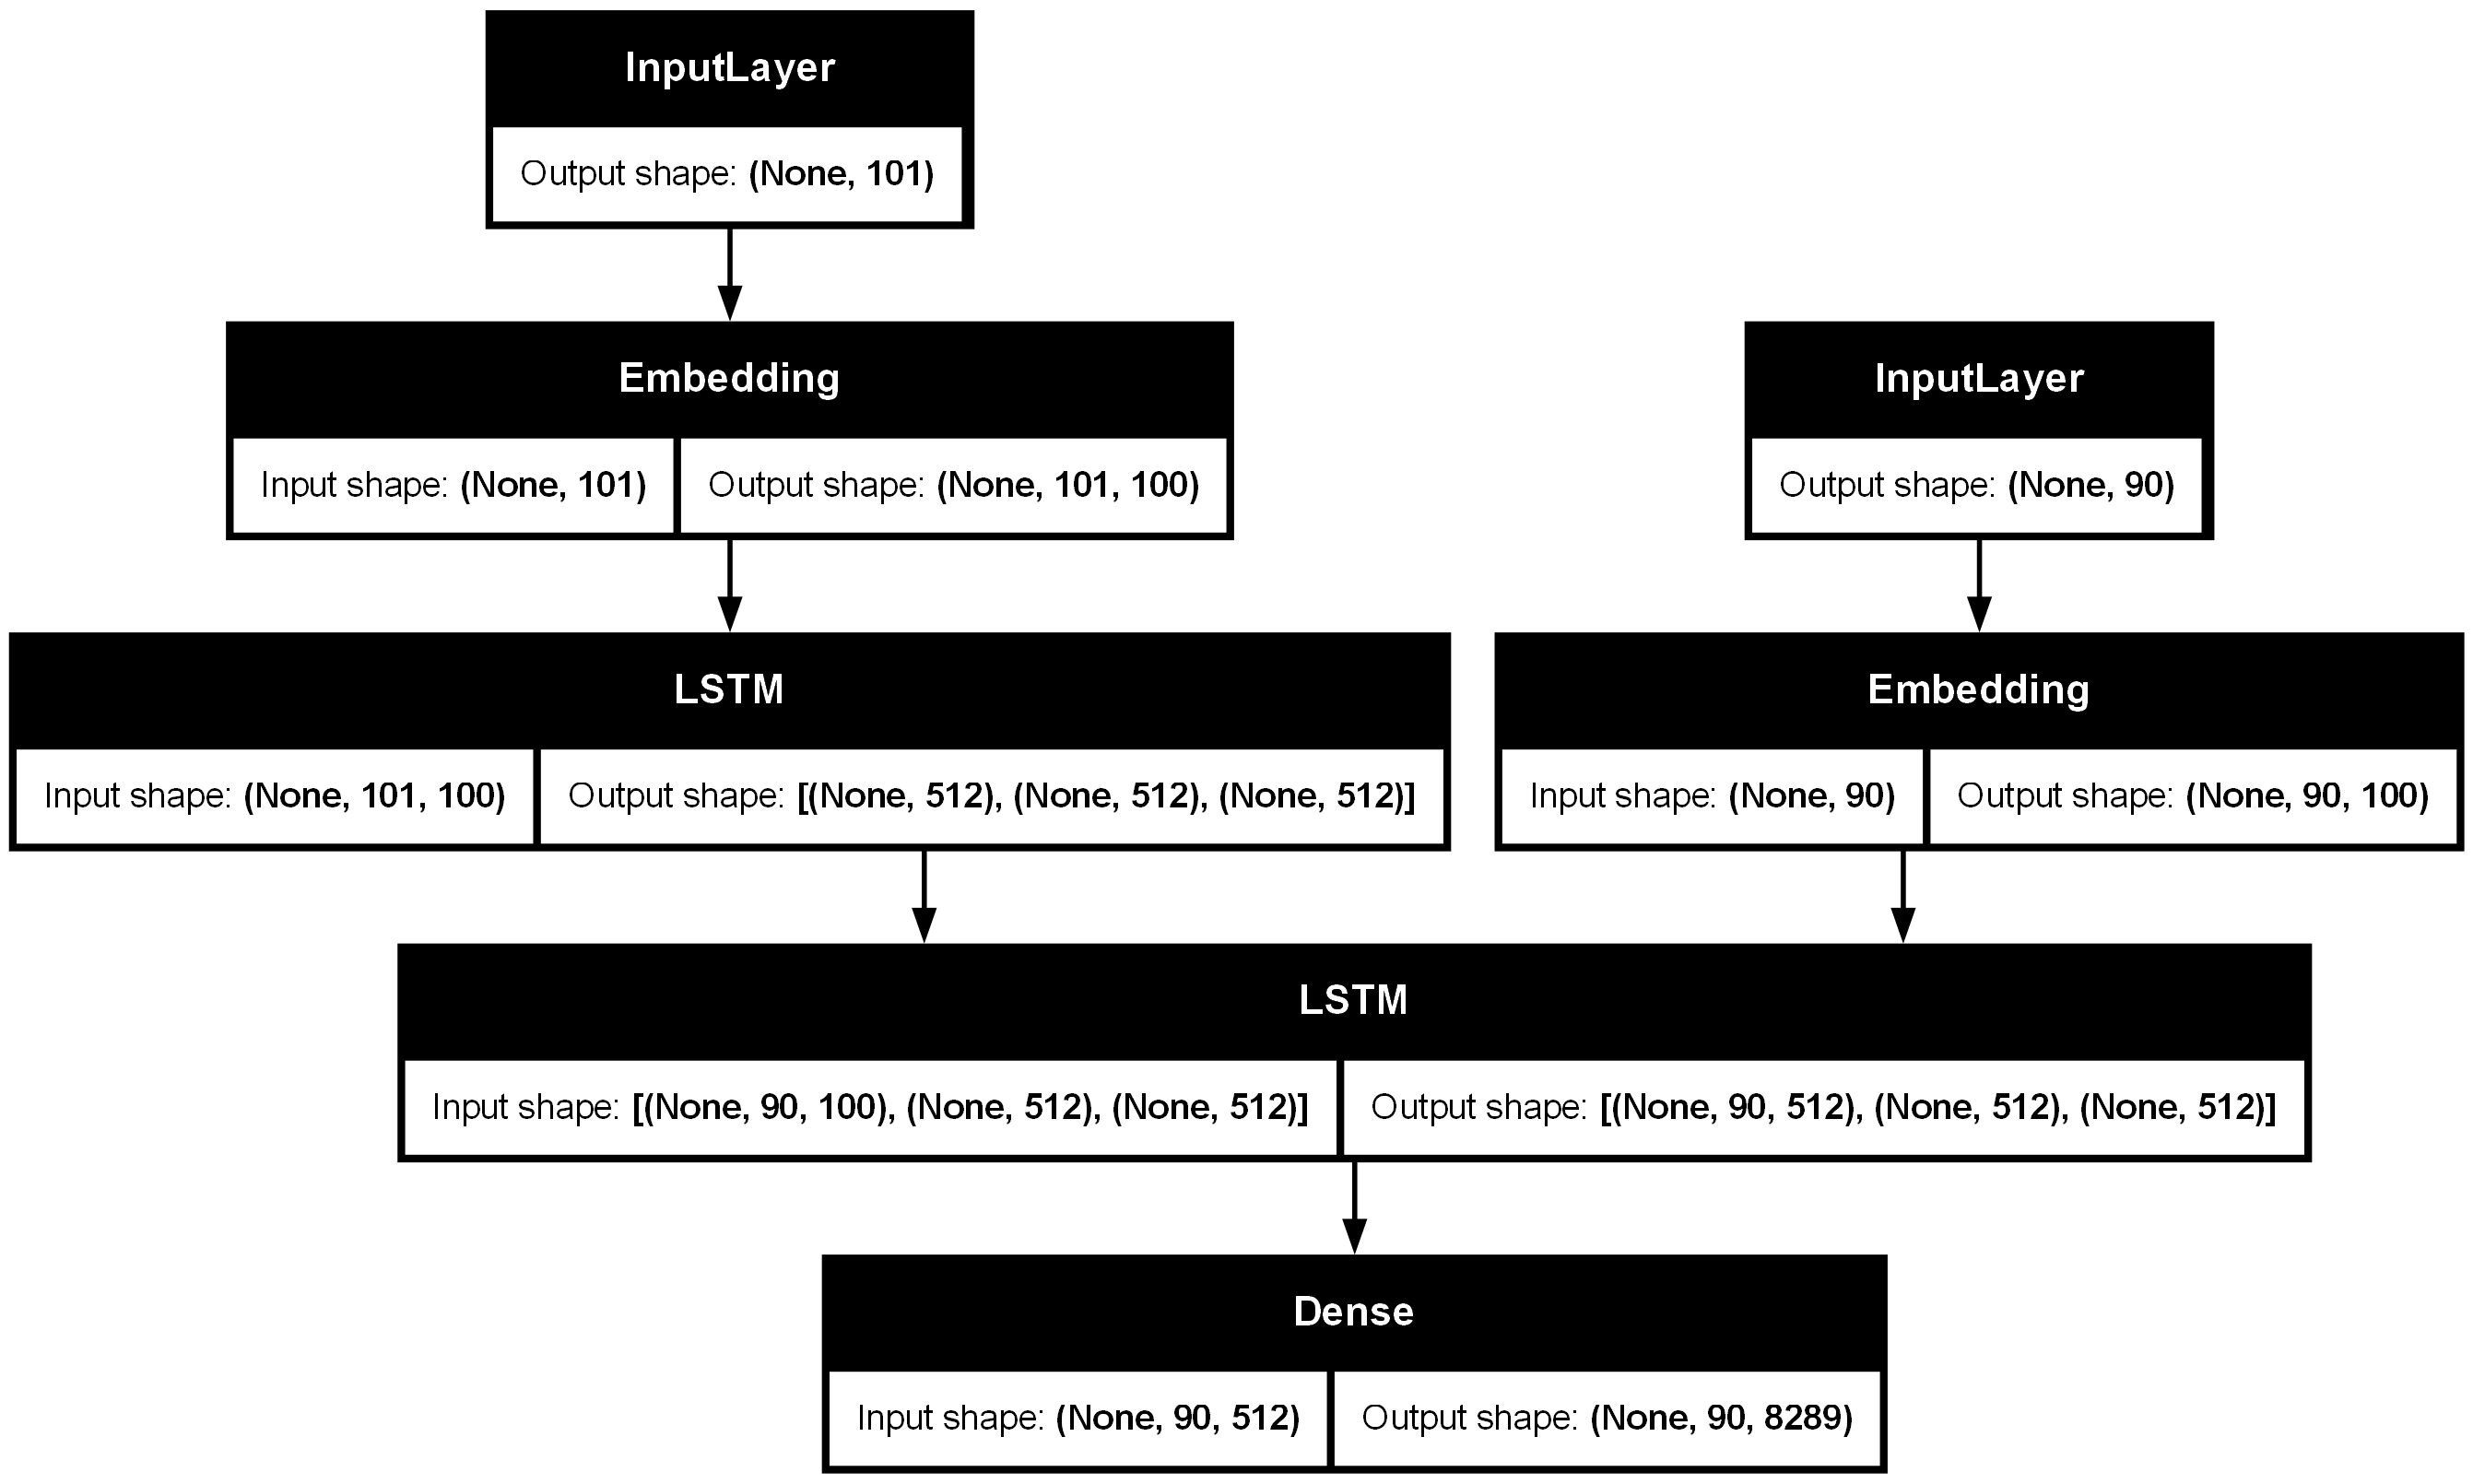

In [24]:
# teacher-forcing model 시각화
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

##### 모델 학습

In [25]:
# decoder_teacher_forcing_model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# history = decoder_teacher_forcing_model.fit(
#     [eng_inputs_padded, kor_inputs_padded],
#     kor_targets_padded,
#     batch_size=64,
#     epochs=70,
#     validation_split=0.2
# )

In [26]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

NameError: name 'history' is not defined

In [ ]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [27]:
# 모델 로드
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model_ = load_model('decoder_teacher_forcing_model.keras')

### 모델 추론
`encoder + decoder(inference)` 구조의 모델로 추론

##### 디코더 추론 모델

In [ ]:
# 입력 states (이전 timestep의 hidden_state, cell_state)
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

# 토큰 입력 (이전 timestep의 output)
decoder_single_input = layers.Input(shape=(1,))

# 학습된 임베딩
x = ko_embedding_layer(decoder_single_input)

# 학습된 LSTM
x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

# 학습된 dense
decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states
)

decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    828,900 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[1][0… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 8289)   │  4,252,257 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,336,581 (24.17 MB)

 Trainable params: 6,336,581 (24.17 MB)

 Non-trainable params: 0 (0.00 B)